In [1]:
# Librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t
from scipy.optimize import curve_fit

import matplotlib.colors as mc
import colorsys

In [2]:
# Funciones
def OLS_regr(X, Y, **kwargs):
    """
    Realiza una regresión lineal por mínimos cuadrados ordinarios (OLS).

    Calcula los parámetros `a` y `b` de una recta ajustada `Y = aX + b`, junto con los errores estándar,
    el coeficiente de correlación de Pearson, y opcionalmente, las incertidumbres de los parámetros si se
    proporcionan errores en las variables `X` e `Y`.

    Parameters
    ----------
    X : array_like
        Vector de valores independientes.
    Y : array_like
        Vector de valores dependientes.
    **kwargs : dict, opcional
        Argumentos opcionales que permiten incluir incertidumbres en los datos:

        - 'Delta_X' : array_like
            Errores estándar asociados a cada valor de `X`.
        - 'Delta_Y' : array_like
            Errores estándar asociados a cada valor de `Y`.

    Returns
    -------
    a : float
        Pendiente de la recta ajustada.
    b : float
        Ordenada al origen (intersección con el eje Y).
    SE_a : float
        Error estándar de la pendiente.
    SE_b : float
        Error estándar de la ordenada al origen.
    r : float
        Coeficiente de correlación de Pearson.

    Si se proporcionan `Delta_X` y `Delta_Y`, también se devuelven:

    Delta_a : float
        Incertidumbre propagada en la pendiente a partir de los errores en `X` e `Y`.
    Delta_b : float
        Incertidumbre propagada en la ordenada al origen a partir de los errores en `X` e `Y`.

    Notes
    -----
    La función implementa una regresión lineal clásica usando el método de mínimos cuadrados.
    Si el número de observaciones es menor a 30, se aplica una corrección de Student para los errores estándar.
    """

    N = len(X)
    SX = np.sum(X)
    SY = np.sum(Y)
    SXX = np.sum(X*X)
    SYY = np.sum(Y*Y)
    SXY = np.sum(X*Y)

    P1 = SX*SY - N*SXY
    P2 = SX*SXY - SY*SXX
    Q = SX**2 - N*SXX

    a = P1 / Q
    b = P2 / Q

    linear_X = a*X + b
    ji2 = np.sum(np.power(Y - linear_X, 2))

    SE_a = np.sqrt((ji2/(N - 2))*(N/(-Q)))
    SE_b = np.sqrt((ji2/(N - 2))*(SXX/(-Q)))
    r = (-P1)/(np.sqrt((-Q)*(N*SYY - SY**2)))

    if N < 30:
        SE_a *= t.ppf(.975, N - 1)
        SE_b *= t.ppf(.975, N - 1)

    for key, value in kwargs.items():
        if key == 'Delta_X':
            Delta_X = value
            continue
        elif key == 'Delta_Y':
            Delta_Y = value
            continue
    try:
        Delta_X
        Delta_Y
    except NameError:
        return a, b, SE_a, SE_b, r
    else:
        Delta_SX = np.sqrt(np.sum(np.power(Delta_X, 2)))
        Delta_SY = np.sqrt(np.sum(np.power(Delta_Y, 2)))
        Delta_SXX = 2 * np.sqrt(np.sum(np.power(X * Delta_X, 2)))
        Delta_SXY = np.sqrt(np.sum(np.power(X * Delta_Y, 2) + np.power(Delta_X * Y, 2)))

        Delta_P1 = np.sqrt((SX * Delta_SY)**2 + (Delta_SX * SY)**2 + (N * Delta_SXY)**2)
        Delta_P2 = np.sqrt((SX * Delta_SXY)**2 + (Delta_SX * SXY)**2 + (SY * Delta_SXX)**2 + (Delta_SY * SXX)**2)
        Delta_Q = np.sqrt(4 * (SX * Delta_SX)**2 + (N * Delta_SXX)**2)

        Delta_a = np.sqrt((Delta_P1 * Q)**2 + (P1 * Delta_Q)**2)
        Delta_b = np.sqrt((Delta_P2 * Q)**2 + (P2 * Delta_Q)**2)

        return a, b, SE_a, SE_b, Delta_a, Delta_b, r

def ajustes_lineales(X_arrays, Y_arrays, Delta_X, Delta_Y):
    num_ajustes = len(X_arrays)
    ajustes = np.empty((num_ajustes, 7))

    i = 0
    for X, Y in zip(X_arrays, Y_arrays):
        X = X[~np.isnan(X)]
        Y = Y[~np.isnan(Y)]
        ajustes[i] = np.array(OLS_regr(X, Y, Delta_X=Delta_X, Delta_Y=Delta_Y), dtype=np.float64)
        i += 1

    ajustes = np.transpose(ajustes)
    ajustes[-1] = np.power(ajustes[-1], 2)

    Delta_a = np.sqrt(np.power(ajustes[2], 2) + np.power(ajustes[4], 2))
    Delta_b = np.sqrt(np.power(ajustes[3], 2) + np.power(ajustes[5], 2))

    return ajustes, Delta_a, Delta_b


def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [3]:
# Misc.
df_center = [
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}]

colors = ['b', 'darkorange', 'forestgreen', 'r', 'blueviolet']
markers = ['o', 's', 'D', '^', 'X']
linestyles = ['-', '--', ':', '-.', '-']
plt.rcParams.update({
    "text.usetex": True,
    # "text.latex.preamble": r"\usepackage{bm}",
    # "font.size": 18,
    # "font.family": "serif"
})

In [4]:
# Extracción de datos
base_url = 'https://raw.githubusercontent.com/errodriguezs/Experimentos_Moderna_25-2/refs/heads/main/Estado%20s%C3%B3lido/datos/'
data_filenames = ['VH%20vs%20B%20(lento).csv', 'VH%20vs%20B%20(rapido).csv', 'VH%20vs%20I.csv', 'VH%20vs%20T.csv', ]

dataframes = []
numpy_arrays = []
for filename in data_filenames:
    df = pd.read_csv(base_url + filename)
    dataframes.append(df)
    numpy_arrays.append(np.transpose(df.to_numpy(dtype=np.float64)))

In [5]:
# Separación de los datos
datos_B_variable = {
    'lento': {
        'VH': numpy_arrays[0][1::2] * 1e-3,  # [V]
        'B': numpy_arrays[0][::2] * 1e-3,  # [T]
        'I': np.array([15.0, 20.1, 25.0, 30.1], dtype=np.float64) * 1e-3  # [A]
    },
    'rapido': {
        'VH': numpy_arrays[1][1::2] * 1e-3,  # [V]
        'B': numpy_arrays[1][::2] * 1e-3,  # [T]
        'I': np.array([15.1, 19.9, 25.0, 30.0], dtype=np.float64) * 1e-3  # [A]
    }
}

datos_I_variable = {
    'VH': numpy_arrays[2][1::2] * 1e-3,  # [V]
    'I': numpy_arrays[2][::2] * 1e-3,  # [A]
    'I_B': np.array([1, 2, 3, 4, 5], dtype=np.float64),  # [A]
    'B': np.array([84.75, 145.05, 210.30, 273.15, 308.10], dtype=np.float64) * 1e-3  # [T]
}

datos_T_variable = {
    'VH': numpy_arrays[3][1] * 1e-3,  # [V]
    'T': numpy_arrays[3][0],  # [K]
    'B': 342.0 * 1e-3,  # [T]
    'I': 30.0 * 1e-3  # [A]
}

datos_caída_de_potencial = {
    'V': np.array([0.75, 1, 1.23, 1.48], dtype=np.float64),  # [V]
    'I': np.array([15, 20.3, 25, 30.1], dtype=np.float64) * 1e-3  # [A]
}

In [6]:
# Correcciones
lims_lento = [-20, -14, -33, -27]
lims_rapido = [-12, -19, -10, -10]
lims_corriente = [-15, -54, -42, -45, -50]

for i in range(4):
    S = lims_lento[i]
    F = lims_rapido[i]
    II = lims_corriente[i]

    datos_B_variable['lento']['VH'][i][S:] = np.nan
    datos_B_variable['lento']['B'][i][S:] = np.nan

    datos_B_variable['rapido']['VH'][i][F:] = np.nan
    datos_B_variable['rapido']['B'][i][F:] = np.nan

    datos_I_variable['I'][i][II:] = np.nan
    datos_I_variable['VH'][i][II:] = np.nan

datos_I_variable['I'][4][II:] = np.nan
datos_I_variable['VH'][4][II:] = np.nan

In [7]:
# Constantes e incertidumbres
# https://pml.nist.gov/cgi-bin/cuu/Value?e|search_for=elecmag_in!
e_0 = 1.602176634e-19  # [C]

b = 20 * 1e-3  # [m]
w = 10 * 1e-3  # [m]
d = 1 * 1e-3  # [m] (es el mismo valor de la incertidumbre de las longitudes)
constante_ajuste_T = datos_T_variable['I'] * datos_T_variable['B'] / (e_0 * d)

# Incertidumbres instrumentales
Delta_V = 0.01  # [V]
Delta_VH = 0.1 * 1e-3  # [V]
Delta_I = 0.1 * 1e-3  # [A]
Delta_I_B = 0.01  # [A]
Delta_B = 0.15 * 1e-3  # [T]
Delta_T = 0.1  # [K]

In [8]:
# Ajustes para $I$ variable (OLS)
ajustes_I_variable, Delta_a_I_variable, Delta_b_I_variable = (
    ajustes_lineales(datos_I_variable['I'], datos_I_variable['VH'],
                     Delta_I, Delta_VH)
)

x_lims_I = np.array([0, 31])
y_lims_I = np.array([-2, 80])

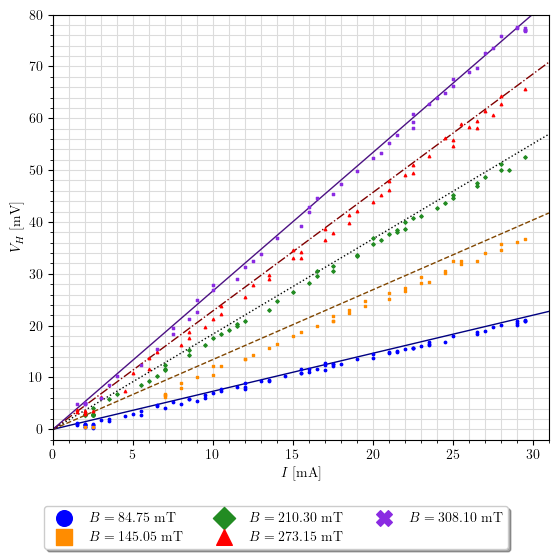

In [23]:
# Gráfica de los ajustes ($V_H$ vs $I$)
fig, ax = plt.subplots(layout='constrained')#, figsize=(8.8, 5.5))
for i in range(len(datos_I_variable['I'])):
    campo = datos_I_variable['B'][i] * 1e+3
    a = ajustes_I_variable[0][i]
    b = ajustes_I_variable[1][i]

    ax.scatter(
        datos_I_variable['I'][i] * 1e+3,
        datos_I_variable['VH'][i] * 1e+3,
        marker=markers[i],
        s=3,
        fc=colors[i],
        zorder=3,
        label=f'$B = {campo:.2f}' '\\; \\mathrm{mT}$'
    )
    ax.plot(
        x_lims_I,
        a * x_lims_I + b,
        ls=linestyles[i],
        lw=1,
        c=lighten_color(colors[i], 1.5),
        zorder=2
    )
ax.grid(True, which='both', color='gainsboro', zorder=0)
ax.minorticks_on()
ax.set_xlabel(r'$I \; [\mathrm{mA}]$')
ax.set_ylabel(r'$V_H \; [\mathrm{mV}]$')
ax.set_xlim(x_lims_I)
ax.set_ylim(y_lims_I)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.14), fancybox=True, shadow=True, ncol=3, markerscale=6.5)

# plt.savefig("graficas\\resultados_corriente.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [10]:
# Tabla de resultados de los ajustes $V_H$ vs $I$
df = pd.DataFrame({
    r'$B$ [±0.15 mT]': datos_I_variable['B'] * 1e+3,
    r'$a$ [$\Omega$]': ajustes_I_variable[0],
    r'$\Delta a$ [$\Omega$]': Delta_a_I_variable,
    r'$b$ [V]': ajustes_I_variable[1],
    r'$\Delta b$ [V]': Delta_b_I_variable,
    r'$R^2$': ajustes_I_variable[6]
})

df.index += 1
df = df.style.set_table_styles(df_center)
display(df)

,$B$ [±0.15 mT],$a$ [$\Omega$],$\Delta a$ [$\Omega$],$b$ [V],$\Delta b$ [V],$R^2$
1,84.750000,0.733837,0.004750,-0.000587,0.000078,0.996870
2,145.050000,1.346453,0.010389,-0.002419,0.000196,0.997447
3,210.300000,1.836669,0.007955,-0.001119,0.000135,0.998979
4,273.150000,2.285056,0.014163,-0.001203,0.000248,0.998013
5,308.100000,2.670582,0.013449,-0.000665,0.000255,0.998693


In [11]:
# Ajustes para $B$ variable (OLS)
# Lento
ajustes_B_variable_lento, Delta_a_B_variable_lento, Delta_b_B_variable_lento = (
    ajustes_lineales(datos_B_variable['lento']['B'],
                     datos_B_variable['lento']['VH'], Delta_B, Delta_VH)
)
x_lims_B_lento = np.array([0, 320])
y_lims_B_lento = np.array([-2, 64])

# Rápido
ajustes_B_variable_rapido, Delta_a_B_variable_rapido, Delta_b_B_variable_rapido = (
    ajustes_lineales(datos_B_variable['rapido']['B'],
                     datos_B_variable['rapido']['VH'], Delta_B, Delta_VH)
)
x_lims_B_rapido = np.array([0, 320])
y_lims_B_rapido = np.array([-2, 64])

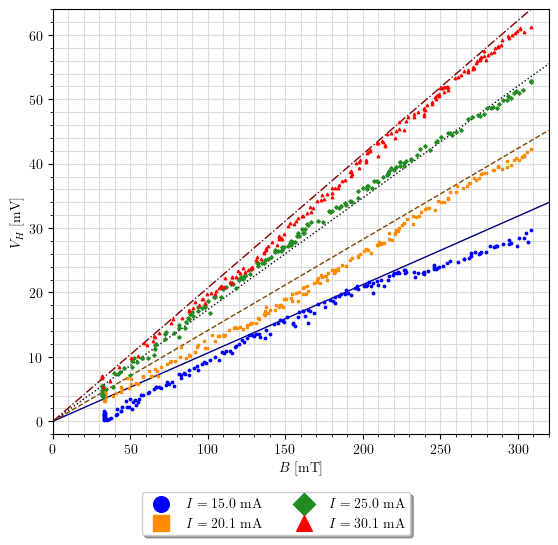

In [24]:
# Gráfica de los ajustes ($V_H$ vs $B$, lento)
fig, ax = plt.subplots(layout='constrained')#, figsize=(8.8, 5.5))
for i in range(len(datos_B_variable['lento']['B'])):
    corriente = datos_B_variable['lento']['I'][i] * 1e+3
    a = ajustes_B_variable_lento[0][i]
    b = ajustes_B_variable_lento[1][i]

    ax.scatter(
        datos_B_variable['lento']['B'][i] * 1e+3,
        datos_B_variable['lento']['VH'][i] * 1e+3,
        marker=markers[i],
        s=3,
        fc=colors[i],
        zorder=3,
        label=f'$I = {corriente:.1f}' r'\; \mathrm{mA}$'
    )
    ax.plot(
        x_lims_B_lento,
        a * x_lims_B_lento + b,
        ls=linestyles[i],
        lw=1,
        c=lighten_color(colors[i], 1.5),
        zorder=2
    )
ax.grid(True, which='both', color='gainsboro', zorder=0)
ax.minorticks_on()
ax.set_xlabel(r'$B \; [\mathrm{mT}]$')
ax.set_ylabel(r'$V_H \; [\mathrm{mV}]$')
ax.set_xlim(x_lims_B_lento)
ax.set_ylim(y_lims_B_lento)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.12), fancybox=True, shadow=True, ncol=2, markerscale=6.5)

# plt.savefig("graficas\\resultados_campoB.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [13]:
# Tabla de resultados de los ajustes $V_H$ vs $B$ (lento)
df = pd.DataFrame({
    r'$I$ [±0.1 mA]': datos_B_variable['lento']['I'] * 1e+3,
    r'$a$ [T/V]': ajustes_B_variable_lento[0],
    r'$\Delta a$ [T/V]': Delta_a_B_variable_lento,
    r'$b$ [V]': ajustes_B_variable_lento[1],
    r'$\Delta b$ [V]': Delta_b_B_variable_lento,
    r'$R^2$': ajustes_B_variable_lento[6]
})

df.index += 1
df = df.style.set_table_styles(df_center)
display(df)

,$I$ [±0.1 mA],$a$ [T/V],$\Delta a$ [T/V],$b$ [V],$\Delta b$ [V],$R^2$
1,15.000000,0.106186,11.589263,-0.001728,1.763113,0.983757
2,20.100000,0.141276,12.422846,-0.001798,1.973887,0.995940
3,25.000000,0.173537,8.601226,0.000570,1.356641,0.995967
4,30.100000,0.207456,9.996175,-0.001257,1.820603,0.998154


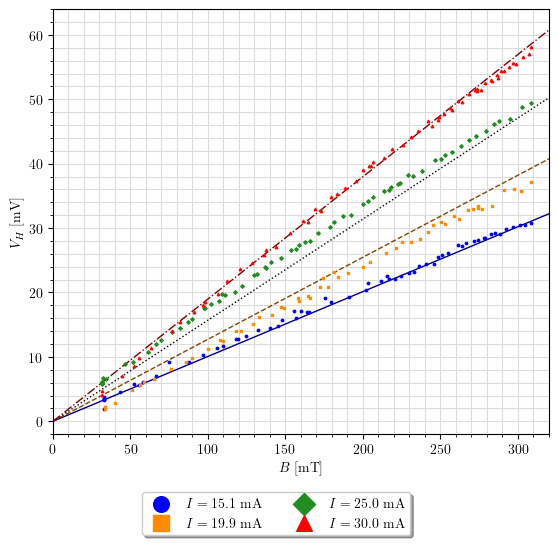

In [25]:
# Gráfica de los ajustes ($V_H$ vs $B$, rápido)
fig, ax = plt.subplots(layout='constrained')#, figsize=(8.8, 5.5))
for i in range(len(datos_B_variable['rapido']['B'])):
    corriente = datos_B_variable['rapido']['I'][i] * 1e+3
    a = ajustes_B_variable_rapido[0][i]
    b = ajustes_B_variable_rapido[1][i]

    ax.scatter(
        datos_B_variable['rapido']['B'][i] * 1e+3,
        datos_B_variable['rapido']['VH'][i] * 1e+3,
        marker=markers[i],
        s=3,
        fc=colors[i],
        zorder=3,
        label=f'$I = {corriente:.1f}' r'\; \mathrm{mA}$'
    )
    ax.plot(
        x_lims_B_rapido,
        a * x_lims_B_rapido + b,
        ls=linestyles[i],
        lw=1,
        c=lighten_color(colors[i], 1.5),
        zorder=2
    )
ax.grid(True, which='both', color='gainsboro', zorder=0)
ax.minorticks_on()
ax.set_xlabel(r'$B \; [\mathrm{mT}]$')
ax.set_ylabel(r'$V_H \; [\mathrm{mV}]$')
ax.set_xlim(x_lims_B_lento)
ax.set_ylim(y_lims_B_lento)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.12), fancybox=True, shadow=True, ncol=2, markerscale=6.5)

# plt.savefig("graficas\\resultados_campoB_rapido.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [15]:
# Tabla de resultados de los ajustes $V_H$ vs $B$ (rápido)
df = pd.DataFrame({
    r'$I$ [±0.1 mA]': datos_B_variable['rapido']['I'] * 1e+3,
    r'$a$ [T/V]': ajustes_B_variable_rapido[0],
    r'$\Delta a$ [T/V]': Delta_a_B_variable_rapido,
    r'$b$ [V]': ajustes_B_variable_rapido[1],
    r'$\Delta b$ [V]': Delta_b_B_variable_rapido,
    r'$R^2$': ajustes_B_variable_rapido[6]
})

df.index += 1
df = df.style.set_table_styles(df_center)
display(df)

,$I$ [±0.1 mA],$a$ [T/V],$\Delta a$ [T/V],$b$ [V],$\Delta b$ [V],$R^2$
1,15.100000,0.100700,0.287727,0.000408,0.051701,0.997125
2,19.900000,0.127375,0.162966,-0.001478,0.028510,0.997428
3,25.000000,0.156990,0.269780,0.001836,0.044298,0.998518
4,30.000000,0.189875,0.339249,-0.000224,0.067579,0.998100


In [16]:
# Valores estimados de $R_H$
RH_I, _, Delta_RH_I, _, R_RH_I = OLS_regr(datos_I_variable['B'] / d, ajustes_I_variable[0])
RH_B_lento, _, Delta_RH_B_lento, _, R_RH_B_lento = OLS_regr(datos_B_variable['lento']['I'] / d, ajustes_B_variable_lento[0])
RH_B_rapido, _, Delta_RH_B_rapido, _, R_RH_B_rapido = OLS_regr(datos_B_variable['rapido']['I'] / d, ajustes_B_variable_rapido[0])

RH = np.array([RH_I, RH_B_lento, RH_B_rapido], dtype=np.float64)
Delta_RH = np.array([Delta_RH_I, Delta_RH_B_lento, Delta_RH_B_rapido], dtype=np.float64)

print(f'·     VH vs I:      R_H = ({RH_I * 1e+3:.1f} ± {Delta_RH_I * 1e+3:.1f}) × 10⁻³ m³ / C')
print(f'                     R² =  {R_RH_I ** 2:.4f}')
print(f'· VH vs B (lento):  R_H = ({RH_B_lento * 1e+3:.1f} ± {Delta_RH_B_lento * 1e+3:.1f}) × 10⁻³ m³ / C')
print(f'                     R² =  {R_RH_B_lento ** 2:.4f}')
print(f'· VH vs B (rápido): R_H = ({RH_B_rapido * 1e+3:.1f} ± {Delta_RH_B_rapido * 1e+3:.1f}) × 10⁻³ m³ / C')
print(f'                     R² =  {R_RH_B_rapido ** 2:.4f}')

·     VH vs I:      R_H = (8.3 ± 0.9) × 10⁻³ m³ / C
                     R² =  0.9951
· VH vs B (lento):  R_H = (6.7 ± 0.1) × 10⁻³ m³ / C
                     R² =  0.9999
· VH vs B (rápido): R_H = (6.0 ± 0.5) × 10⁻³ m³ / C
                     R² =  0.9985


In [17]:
# Función de $V_H = V_H(T)$
def VH_respecto_T(T, A1, B1, C, D):
    global constante_ajuste_T
    A = A1 * 1e21
    B = B1 * 1e26
    # B = B1 * 1e19

    raiz = np.sqrt((A ** 2) / 4 + (B ** 2) * np.exp(-C * 13025.9 / T))
    numerador = (A + (raiz - A / 2) * (1 - D ** 2)) * constante_ajuste_T
    denominador = (A + (raiz - A / 2) * (1 + D)) ** 2

    return numerador / denominador

In [18]:
# Ajuste $T$ variable (NLS)
beta_guess = [
    1.17,  # [m *]
    1.99,  # [portadores / m³ *]
    0.74,  # [eV]
    1.81  # k de la guía
]
# beta_guess = [
#     1.17,  # [m *]
#     2.3,  # [portadores / m³ *]
#     0.66,  # [eV]
#     3.00  # k de la guía
# ]

X = datos_T_variable['T']
Y = datos_T_variable['VH']
parametros_ajuste_T, mcov_ajuste_T = (
    curve_fit(VH_respecto_T, X, Y, p0=beta_guess, sigma=Delta_VH,
              bounds=([0, 0, 0, 0], [np.inf, np.inf, 5, 10]))
)

x_ajuste_T = np.linspace(300, 550, num=100)
y_ajuste_T = VH_respecto_T(x_ajuste_T, *parametros_ajuste_T)

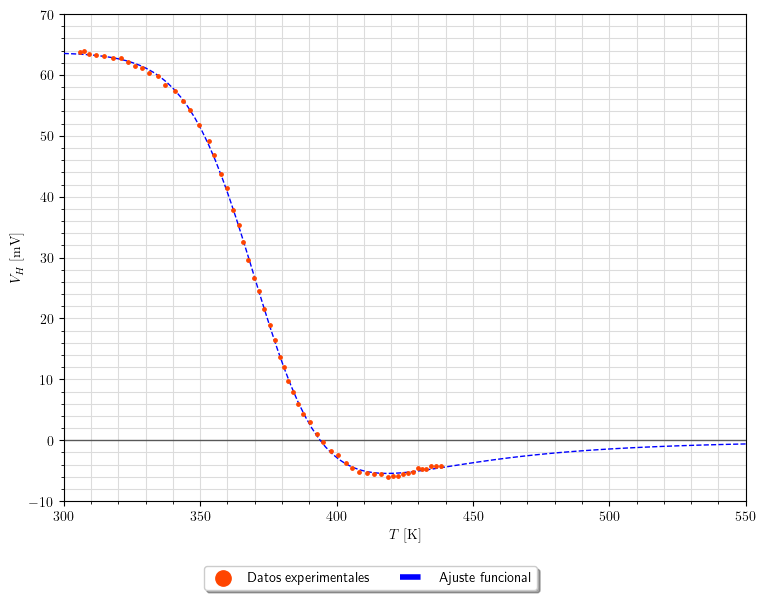

In [19]:
# Gráfica del ajuste ($V_H$ vs $T$)
fig, ax = plt.subplots(layout='constrained', figsize=(8.8, 5.5))

ax.scatter(
    datos_T_variable['T'],
    datos_T_variable['VH'] * 1e+3,
    s=6,
    fc='orangered',
    zorder=4,
    label='Datos experimentales'
)
ax.plot(
    x_ajuste_T,
    y_ajuste_T * 1e+3,
    ls='--',
    lw=1,
    c='b',
    zorder=3,
    label='Ajuste funcional'
)
ax.axhline(0, 0, 1, color='k', alpha=.6, lw=1, zorder=2)
ax.grid(True, which='both', color='gainsboro', zorder=0)
ax.minorticks_on()
ax.set_xlabel(r'$T \; [\mathrm{K}]$')
ax.set_ylabel(r'$V_H \; [\mathrm{mV}]$')
ax.set_xlim([x_ajuste_T[0], x_ajuste_T[-1]])
ax.set_ylim([-10, 70])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.15])
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.45, -0.12), fancybox=True, shadow=True, ncol=2, markerscale=4.5)
for line in leg.get_lines():
    line.set_linewidth(4.0)

# plt.savefig("graficas\\V_H(T).pdf", format="pdf", bbox_inches='tight')
plt.show()

In [20]:
# Reporte de parámetros del ajuste $V_H$ vs $T$ (NLS)
variables = ['P_S', 'N_0', 'E_g', 'k']
unidades = ['× 10²¹ huecos / m³', '× 10²⁶ portadores / m³', 'eV', '']

for var, param, err, unidad in zip(variables, parametros_ajuste_T, np.sqrt(np.diag(mcov_ajuste_T) / len(X)), unidades):
    print(f'· {var} = ({param:.4f} ± {err:.4f}) {unidad}')

· P_S = (1.0060 ± 0.0002) × 10²¹ huecos / m³
· N_0 = (2.2416 ± 0.0247) × 10²⁶ portadores / m³
· E_g = (0.7569 ± 0.0006) eV
· k = (1.7818 ± 0.0009) 


## Determinación de $\mu_p$

De la ecuación (XIII):
$$
\mu_p = \frac{V_H \cdot w}{b \cdot B \cdot V,}
$$

donde $V$ es la caída de potencial medida. Al reemplazar $V_H$ de la ecuación (I):
$$
\mu_p = \frac{R_H \cdot I \cdot w}{d \cdot b \cdot U}
$$

despejando $U$ se obtiene:
$$
U = \frac{R_H\cdot w}{d \cdot b \cdot \mu_p} \cdot I
$$

una ecuación de la que se puede calcular una regresión lineal (OLS, $Y = aX + b$) tal que
$$
\begin{cases}
X = I \\
V = Y
\end{cases} \implies
\begin{cases}
a = \frac{R_H\cdot w}{d \cdot b \cdot \mu_p}\\
b \approx 0
\end{cases}
$$

es decir,
$$
\boxed{ \mu_p = \frac{R_H\cdot w}{d \cdot b \cdot a} }
$$

## Determinación de $v_p$

Como al multiplicar la ecuación (VIII) por $V / w$ se obtiene la ecuación (VII), entonces,
$$
\boxed{v_p = \frac{V}{w} \cdot \mu_p}
$$

In [21]:
# Determinación de $v_p$ y $\mu_p$
ajuste_caida_potencial = np.array(
    OLS_regr(datos_caída_de_potencial['I'], datos_caída_de_potencial['V'],
             Delta_X=Delta_I, Delta_Y=Delta_V),
    dtype=np.float64
    )
a = ajuste_caida_potencial[0]
Delta_a = np.sqrt(ajuste_caida_potencial[2] ** 2 + ajuste_caida_potencial[4] ** 2)
R2 = ajuste_caida_potencial[6] ** 2

mu_p = - RH[1] * w / (d * b * ajuste_caida_potencial[0])
Delta_mu_p = mu_p * np.sqrt((Delta_RH[1] / RH[1]) ** 2 + (d / w) ** 2 + (Delta_a / a) ** 2) # + (d / d) ** 2

v_p = datos_caída_de_potencial['V'] * mu_p / w
Delta_v_p = v_p * np.sqrt((Delta_V / datos_caída_de_potencial['V']) ** 2 + (Delta_mu_p / mu_p) ** 2 + (d / w) ** 2)

In [22]:
# Reporte de los valores estimados de $\mu_p$ y $v_p$
print(f'Valor estimado de la movilidad de los huecos: μ_p = ({mu_p:.1f} ± {Delta_mu_p:.1f}) m² V⁻¹ s⁻¹')
print(f'                                               R² = {R2:.4f}')

df = pd.DataFrame({
    r'$V$ [$\pm$ 0.01 V]': datos_caída_de_potencial['V'],
    r'$v_p$ [m/s]': v_p,
    r'$\Delta v_p$ [m/s]': Delta_v_p
})

df.index += 1
df = df.style.set_table_styles(df_center)
display(df)

Valor estimado de la movilidad de los huecos: μ_p = (6.2 ± 0.6) m² V⁻¹ s⁻¹
                                               R² = 0.9999


,$V$ [$\pm$ 0.01 V],$v_p$ [m/s],$\Delta v_p$ [m/s]
1,0.750000,463.415273,67.311954
2,1.000000,617.887030,89.583690
3,1.230000,760.001047,110.099047
4,1.480000,914.472805,132.412359
